In [2]:
# import necessary libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle

/Users/weilunteo/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [79]:
df = pd.read_csv('platform_dataset.csv')

df


,Type of Product,Date of Purchase,Cost of Purchase,Qty of Purchase,Customer ID,Seller Brand,Seller ID,Rating,Time Taken for Transaction (s),Month of Transaction,Time of Transaction,return
0,Household Essentials,11/12/2021,296.19,8,64558,Unilever,348,3,21.88,12,23:45,0
1,Fashion,10/10/2020,570.26,3,86183,Oysho,683,1,99.90,10,19:15,0
2,Fashion,07/02/2020,776.28,2,68292,Boohoo,429,1,44.16,2,06:45,0
3,Fashion,11/08/2020,325.18,6,76947,Miss Selfridge,677,5,110.75,8,19:45,1
4,Fashion,11/07/2021,407.98,2,41309,River Island,422,3,40.59,7,00:30,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Fashion,07/01/2020,664.69,2,66333,Ally Fashion,757,5,8.04,1,19:00,1
9996,Fashion,26/07/2021,38.83,8,62067,Fashion Nova,579,4,14.76,7,21:15,1
9997,Fashion,28/08/2021,168.13,10,76251,Zalando,783,1,72.84,8,15:45,0
9998,Fashion,29/05/2020,488.81,7,14564,Nasty Gal,145,3,60.22,5,23:30,0


In [80]:
df.describe()

,Cost of Purchase,Qty of Purchase,Customer ID,Seller ID,Rating,Time Taken for Transaction (s),Month of Transaction,return
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,498.662359,5.527700,54638.404600,543.747400,3.014100,59.472283,6.111400,0.402500
std,289.967500,2.864132,25933.078744,258.865612,1.411985,34.682244,3.573915,0.490426
min,0.350000,1.000000,10008.000000,100.000000,1.000000,0.010000,1.000000,0.000000
25%,246.777500,3.000000,32014.750000,318.000000,2.000000,28.840000,3.000000,0.000000
50%,496.470000,6.000000,54659.000000,540.500000,3.000000,59.640000,6.000000,0.000000
75%,751.825000,8.000000,76725.000000,765.000000,4.000000,89.110000,9.000000,1.000000
max,999.940000,10.000000,99998.000000,999.000000,5.000000,119.990000,12.000000,1.000000


In [81]:
df.columns

Index(['Type of Product', 'Date of Purchase', 'Cost of Purchase',
       'Qty of Purchase', 'Customer ID', 'Seller Brand', 'Seller ID', 'Rating',
       'Time Taken for Transaction (s)', 'Month of Transaction',
       'Time of Transaction', 'return'],
      dtype='object')

### Classification model
##### Predict whether it will be a successful transaction

In [83]:
# Separate input (X) and target (y) dataframes
# --------------------------------------------

X = df[['Date of Purchase', 'Time of Transaction', 'Qty of Purchase', 'Cost of Purchase', 'Rating']]
y = df['return']

print(X.shape,y.shape)

(10000, 5) (10000,)


In [84]:
# distribution of class
#----------------------
print(y.value_counts())

0    5975
1    4025
Name: return, dtype: int64


In [85]:
def preprocess_data(X):
    # for numerical columns
    # ---------------------
    # we normalize using MinMaxScaler to constrain values between 0 and 1

    scaler = MinMaxScaler(feature_range = (0,1))
    df_numeric = X.select_dtypes(include=[np.number])
    numeric_cols = df_numeric.columns.values

    for col in numeric_cols:
        # fit_transform() of scaler can be applied to each column individually
        X[col] = scaler.fit_transform(X[[col]])
        
    print("---Successfully processed numeric column(s)")
    print(X.head(5))
    
    # for categorical columns
    # -----------------------
    # we convert the column into one-hot encoding
    df_categorical = X.select_dtypes(exclude=[np.number])
    categorical_cols = df_categorical.columns.values
    
    # the function get_dummies() (from pandas) creates one-hot encoding
    X = pd.get_dummies(X,columns=categorical_cols)
           
    print("---Successfully processed categorical column(s)")
    print(X.head(5))
        
    return X

In [86]:
# execute preprocess_data()
#--------------------------
X = preprocess_data(X)

---Successfully processed numeric column(s)
  Date of Purchase Time of Transaction  Qty of Purchase  Cost of Purchase  \
0       11/12/2021               23:45         0.777778          0.295961   
1       10/10/2020               19:15         0.222222          0.570144   
2       07/02/2020               06:45         0.111111          0.776248   
3       11/08/2020               19:45         0.555556          0.324963   
4       11/07/2021               00:30         0.111111          0.407797   

   Rating  
0     0.5  
1     0.0  
2     0.0  
3     1.0  
4     0.5  
---Successfully processed categorical column(s)
   Qty of Purchase  Cost of Purchase  Rating  Date of Purchase_01/01/2020  \
0         0.777778          0.295961     0.5                            0   
1         0.222222          0.570144     0.0                            0   
2         0.111111          0.776248     0.0                            0   
3         0.555556          0.324963     1.0                     

<ipython-input-85-659a51132629>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = scaler.fit_transform(X[[col]])
<ipython-input-85-659a51132629>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = scaler.fit_transform(X[[col]])
<ipython-input-85-659a51132629>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10, stratify = y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 894) (2000, 894) (8000,) (2000,)


In [88]:
# create a logistic regression classifier
# ---------------------------------------
logreg = LogisticRegression(solver='liblinear', random_state=7)
logreg.fit(X_train, y_train)

# Apply the model on the test data to get a prediction
# ----------------------------------------------------
y_pred = logreg.predict(X_test)

Testing accuracy 0.997
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1195
           1       1.00      1.00      1.00       805

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



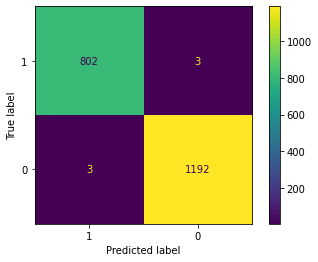

In [90]:
# Get accuracy of the model
# -------------------------
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))


# compute confusion matrix
# ------------------------
labels = [1, 0]
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()

# look at the value for both 'yes' and 'no' class, the model can predict 'no' better than 'yes' 
print(classification_report(y_test, y_pred))

In [91]:
# save the model in a file to retrieve it later if necessary
# ----------------------------------------------------------
filename = 'platform_model.sav'
pickle.dump(logreg, open(filename, 'wb'))

In [92]:
# Recursive Feature Elimination (or RFE)
# --------------------------------------
# Works by recursively removing attributes and building a model 
# on those attributes that remain.
rfe = RFE(logreg, n_features_to_select=3)
fit = rfe.fit(X, y)

print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 3
Selected Features: [False False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False Fal

In [93]:
selected = fit.support_
# get the top-3 feature_names
feature_names = X.columns

# put your code here
# ------------------
print(feature_names.to_numpy()[selected])

['Rating' 'Date of Purchase_05/04/2020' 'Time of Transaction_12:00']


In [39]:
# In case you would like to load the model from disk
loaded_model = pickle.load(open('platform_model.sav', 'rb'))
loaded_model.predict(X_test)

array([0, 0, 1, ..., 0, 0, 0])

### Trying out of CatBoost

Why? Because it automatically deal with categorical variables and does not require extensive data preprocessing

In [61]:
df.head()

,Type of Product,Date of Purchase,Cost of Purchase,Qty of Purchase,Customer ID,Seller Brand,Seller ID,Rating,Time Taken for Transaction (s),Month of Transaction,Time of Transaction,return
0,Household Essentials,11/12/2021,296.19,8,64558,Unilever,348,3,21.88,12,23:45,0
1,Fashion,10/10/2020,570.26,3,86183,Oysho,683,1,99.90,10,19:15,0
2,Fashion,07/02/2020,776.28,2,68292,Boohoo,429,1,44.16,2,06:45,0
3,Fashion,11/08/2020,325.18,6,76947,Miss Selfridge,677,5,110.75,8,19:45,1
4,Fashion,11/07/2021,407.98,2,41309,River Island,422,3,40.59,7,00:30,0


In [97]:
from catboost import CatBoostClassifier
from sklearn import metrics

X = df[['Date of Purchase', 'Time of Transaction', 'Qty of Purchase', 'Cost of Purchase', 'Rating']]
y = df['return']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=5)

# Instantiate the model object
model = CatBoostClassifier(learning_rate=0.1, random_seed=5)

# Fit the model with the training data
model.fit(X_train, y_train, cat_features=([0, 1]))  # set verbose=False if you find the logs too long

# Predict the target on the test dataset
y_predict = model.predict(X_test)
print('\nPrediction on test data', y_predict) 

# Accuracy Score on test dataset
accuracy_test = metrics.accuracy_score(y_test, y_predict)
print('\nAccuracy_score on test dataset : ', accuracy_test)

# F1 Score on test dataset
f1_test = f1_score(y_test, y_predict)
print('\nF1 Score on test dataset : ', f1_test)

# save the model in a file to retrieve it later if necessary
# ----------------------------------------------------------
filename = 'platform_model_catboost.sav'
pickle.dump(logreg, open(filename, 'wb'))

0:	learn: 0.4296849	total: 5.3ms	remaining: 5.29s
1:	learn: 0.2642795	total: 13.1ms	remaining: 6.56s
2:	learn: 0.1686318	total: 17.9ms	remaining: 5.95s
3:	learn: 0.1126271	total: 21.9ms	remaining: 5.45s
4:	learn: 0.0742165	total: 26.8ms	remaining: 5.33s
5:	learn: 0.0544766	total: 29.6ms	remaining: 4.91s
6:	learn: 0.0407669	total: 32.7ms	remaining: 4.63s
7:	learn: 0.0325080	total: 36.7ms	remaining: 4.55s
8:	learn: 0.0243227	total: 41.2ms	remaining: 4.54s
9:	learn: 0.0193105	total: 45ms	remaining: 4.46s
10:	learn: 0.0157141	total: 48.5ms	remaining: 4.36s
11:	learn: 0.0129449	total: 52.5ms	remaining: 4.33s
12:	learn: 0.0109532	total: 56.5ms	remaining: 4.29s
13:	learn: 0.0095715	total: 59.8ms	remaining: 4.21s
14:	learn: 0.0087206	total: 62.8ms	remaining: 4.12s
15:	learn: 0.0079976	total: 65.6ms	remaining: 4.03s
16:	learn: 0.0079169	total: 68.5ms	remaining: 3.96s
17:	learn: 0.0072135	total: 71.6ms	remaining: 3.9s
18:	learn: 0.0070594	total: 74.4ms	remaining: 3.84s
19:	learn: 0.0069652	total

200:	learn: 0.0012885	total: 594ms	remaining: 2.36s
201:	learn: 0.0012884	total: 597ms	remaining: 2.36s
202:	learn: 0.0012884	total: 601ms	remaining: 2.36s
203:	learn: 0.0012884	total: 603ms	remaining: 2.35s
204:	learn: 0.0012884	total: 606ms	remaining: 2.35s
205:	learn: 0.0012884	total: 609ms	remaining: 2.35s
206:	learn: 0.0012884	total: 613ms	remaining: 2.35s
207:	learn: 0.0012884	total: 615ms	remaining: 2.34s
208:	learn: 0.0012884	total: 618ms	remaining: 2.34s
209:	learn: 0.0012884	total: 621ms	remaining: 2.33s
210:	learn: 0.0012884	total: 624ms	remaining: 2.33s
211:	learn: 0.0012884	total: 627ms	remaining: 2.33s
212:	learn: 0.0012884	total: 629ms	remaining: 2.33s
213:	learn: 0.0012883	total: 632ms	remaining: 2.32s
214:	learn: 0.0012883	total: 635ms	remaining: 2.32s
215:	learn: 0.0012883	total: 637ms	remaining: 2.31s
216:	learn: 0.0012883	total: 640ms	remaining: 2.31s
217:	learn: 0.0012883	total: 642ms	remaining: 2.3s
218:	learn: 0.0012883	total: 645ms	remaining: 2.3s
219:	learn: 0.

421:	learn: 0.0012851	total: 1.18s	remaining: 1.61s
422:	learn: 0.0012851	total: 1.18s	remaining: 1.61s
423:	learn: 0.0012851	total: 1.18s	remaining: 1.61s
424:	learn: 0.0012851	total: 1.19s	remaining: 1.61s
425:	learn: 0.0012851	total: 1.19s	remaining: 1.6s
426:	learn: 0.0012851	total: 1.19s	remaining: 1.6s
427:	learn: 0.0012851	total: 1.2s	remaining: 1.6s
428:	learn: 0.0012851	total: 1.2s	remaining: 1.59s
429:	learn: 0.0012851	total: 1.2s	remaining: 1.59s
430:	learn: 0.0012851	total: 1.2s	remaining: 1.59s
431:	learn: 0.0012851	total: 1.21s	remaining: 1.58s
432:	learn: 0.0012851	total: 1.21s	remaining: 1.58s
433:	learn: 0.0012851	total: 1.21s	remaining: 1.58s
434:	learn: 0.0012851	total: 1.21s	remaining: 1.57s
435:	learn: 0.0012850	total: 1.22s	remaining: 1.57s
436:	learn: 0.0012850	total: 1.22s	remaining: 1.57s
437:	learn: 0.0012850	total: 1.22s	remaining: 1.57s
438:	learn: 0.0012850	total: 1.22s	remaining: 1.56s
439:	learn: 0.0012850	total: 1.23s	remaining: 1.56s
440:	learn: 0.00128

642:	learn: 0.0012290	total: 1.77s	remaining: 981ms
643:	learn: 0.0012290	total: 1.77s	remaining: 978ms
644:	learn: 0.0012289	total: 1.77s	remaining: 975ms
645:	learn: 0.0012289	total: 1.77s	remaining: 973ms
646:	learn: 0.0012289	total: 1.78s	remaining: 970ms
647:	learn: 0.0012289	total: 1.78s	remaining: 968ms
648:	learn: 0.0012289	total: 1.78s	remaining: 965ms
649:	learn: 0.0012289	total: 1.79s	remaining: 962ms
650:	learn: 0.0012289	total: 1.79s	remaining: 959ms
651:	learn: 0.0012289	total: 1.79s	remaining: 956ms
652:	learn: 0.0012289	total: 1.79s	remaining: 953ms
653:	learn: 0.0012288	total: 1.8s	remaining: 951ms
654:	learn: 0.0012288	total: 1.8s	remaining: 948ms
655:	learn: 0.0012288	total: 1.8s	remaining: 945ms
656:	learn: 0.0012288	total: 1.8s	remaining: 942ms
657:	learn: 0.0012288	total: 1.81s	remaining: 939ms
658:	learn: 0.0012288	total: 1.81s	remaining: 936ms
659:	learn: 0.0012288	total: 1.81s	remaining: 934ms
660:	learn: 0.0012287	total: 1.81s	remaining: 930ms
661:	learn: 0.00

868:	learn: 0.0012071	total: 2.36s	remaining: 355ms
869:	learn: 0.0012071	total: 2.36s	remaining: 353ms
870:	learn: 0.0012069	total: 2.36s	remaining: 350ms
871:	learn: 0.0012047	total: 2.36s	remaining: 347ms
872:	learn: 0.0012047	total: 2.37s	remaining: 344ms
873:	learn: 0.0012047	total: 2.37s	remaining: 342ms
874:	learn: 0.0012047	total: 2.37s	remaining: 339ms
875:	learn: 0.0012047	total: 2.37s	remaining: 336ms
876:	learn: 0.0012047	total: 2.38s	remaining: 333ms
877:	learn: 0.0012016	total: 2.38s	remaining: 331ms
878:	learn: 0.0012016	total: 2.38s	remaining: 328ms
879:	learn: 0.0012015	total: 2.38s	remaining: 325ms
880:	learn: 0.0012015	total: 2.39s	remaining: 323ms
881:	learn: 0.0012015	total: 2.39s	remaining: 320ms
882:	learn: 0.0012014	total: 2.39s	remaining: 317ms
883:	learn: 0.0012014	total: 2.39s	remaining: 314ms
884:	learn: 0.0012014	total: 2.4s	remaining: 312ms
885:	learn: 0.0012014	total: 2.4s	remaining: 309ms
886:	learn: 0.0012014	total: 2.4s	remaining: 306ms
887:	learn: 0.0

## Trying out XGBoost

In [67]:
X

,Date of Purchase,Time of Transaction,Qty of Purchase,Cost of Purchase,Rating
0,11/12/2021,23:45,8,296.19,3
1,10/10/2020,19:15,3,570.26,1
2,07/02/2020,06:45,2,776.28,1
3,11/08/2020,19:45,6,325.18,5
4,11/07/2021,00:30,2,407.98,3
...,...,...,...,...,...
9995,07/01/2020,19:00,2,664.69,5
9996,26/07/2021,21:15,8,38.83,4
9997,28/08/2021,15:45,10,168.13,1
9998,29/05/2020,23:30,7,488.81,3


In [99]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from xgboost import XGBClassifier


X = df[['Date of Purchase', 'Time of Transaction', 'Qty of Purchase', 'Cost of Purchase', 'Rating']]
y = df['return']

X = preprocess_data(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=5)


# Instantiate the model object
model = xgb.XGBClassifier(learning_rate=0.1, random_state=5, eval_metric='error')

# Fit the model with the training data
model.fit(X_train, y_train)

# predict the target on the test dataset
y_predict = model.predict(X_test)
print('\nPrediction on test data', y_predict) 

# Accuracy Score on test dataset
accuracy_test = metrics.accuracy_score(y_test, y_predict)
print('\nAccuracy_score on test dataset : ', accuracy_test)


# F1 Score on test dataset
f1_test = f1_score(y_test, y_predict)
print('\nF1 Score on test dataset : ', f1_test)

# save the model in a file to retrieve it later if necessary
# ----------------------------------------------------------
filename = 'platform_model_xgboost.sav'
pickle.dump(logreg, open(filename, 'wb'))


<ipython-input-85-659a51132629>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = scaler.fit_transform(X[[col]])
<ipython-input-85-659a51132629>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = scaler.fit_transform(X[[col]])
<ipython-input-85-659a51132629>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

---Successfully processed numeric column(s)
  Date of Purchase Time of Transaction  Qty of Purchase  Cost of Purchase  \
0       11/12/2021               23:45         0.777778          0.295961   
1       10/10/2020               19:15         0.222222          0.570144   
2       07/02/2020               06:45         0.111111          0.776248   
3       11/08/2020               19:45         0.555556          0.324963   
4       11/07/2021               00:30         0.111111          0.407797   

   Rating  
0     0.5  
1     0.0  
2     0.0  
3     1.0  
4     0.5  
---Successfully processed categorical column(s)
   Qty of Purchase  Cost of Purchase  Rating  Date of Purchase_01/01/2020  \
0         0.777778          0.295961     0.5                            0   
1         0.222222          0.570144     0.0                            0   
2         0.111111          0.776248     0.0                            0   
3         0.555556          0.324963     1.0                     

1. LogisticRegression - 99.7%
2. CatBoost - 99.9%
3. XGBoost - Accuracy: 99.9%